In [34]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
import operator

In [35]:
model = ChatOllama(model='qwen3:1.7b')


In [36]:
class EvaluationSchema(BaseModel):
    evaluation: Literal['approved', 'needs_improvement'] = Field(json_schema_extra="Evaluate the post to be eligible for posting on social media platforms")
    feedback: str

evaluator_model = model.with_structured_output(EvaluationSchema)

In [46]:
class PostState(TypedDict):
    topic: str
    generated_post: str
    evaluation: Literal['approved', 'needs_improvement']
    feedback: str
    iteration: int
    max_iteration: int
    post_history = Annotated[list[str], operator.add]
    feedback_history = Annotated[list[str], operator.add]
    

In [38]:
def post_generation(state: PostState) -> PostState:
    prompt = f"Generate a vague twitter post, based on the following topic {state['topic']}"
    response = model.invoke(prompt).content
    return {'generated_post': response, 'post_history': [response]}

In [39]:
def evaluate_post(state: PostState) -> PostState:
    prompt = f"Given the following post {state['generated_post']} \n Generate a feedback on it eligibity to be posted on social media platforms. It should not contain any visual or obsene or disturbing content"
    response = evaluator_model.invoke(prompt)
    return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [ ]:
def optimize_post(state: PostState) -> PostState:
    prompt = f"Given the following post {state['generated_post']} and the feedback {state['feedback']}, regenerate the following post"
    response = model.invoke(prompt).content
    iteration = state['iteration'] + 1
    return {'generated_post': response, 'iteration': iteration, 'post_history': [response]}

In [41]:
def route_evaluation(state: PostState):
    if(state['evaluation'] == "approved"):
        return 'approved'
    
    if(state['evaluation'] == 'needs_improvement'):
        return 'needs_improvement'

In [42]:
graph = StateGraph(PostState)
graph.add_node('generate_post', post_generation)
graph.add_node('evaluate_post', evaluate_post)
graph.add_node('optimize_post', optimize_post)


graph.add_edge(START, 'generate_post')
graph.add_edge('generate_post', 'evaluate_post')
graph.add_conditional_edges('evaluate_post', route_evaluation, {'approved': END, 'needs_improvement': 'optimize_post'})
graph.add_edge('optimize_post', 'evaluate_post')

workflow = graph.compile()

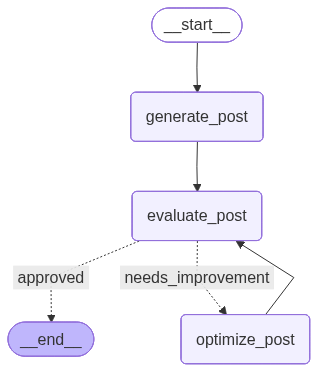

In [43]:
workflow

In [44]:
initial_state = {
    'topic': "Racism in Moscow",
    'iteration': 1,
    'max_iteration': 4
}

final_state = workflow.invoke(initial_state)
print(final_state)

{'topic': 'Racism in Moscow', 'generated_post': '"Moscow\'s vibrant tapestry reflects a mosaic of cultures, yet shadows of inequality linger in its streets. Diversity doesn\'t erase struggles—what echoes in the city\'s pulse remind us that equity is a shared journey, not a single story. #Racism #Moscow #Diversity #SystemicChallenges"', 'evaluation': 'approved', 'feedback': "This post effectively captures the complex interplay of diversity and systemic challenges in Moscow. It acknowledges the city's vibrant cultural mosaic while highlighting the persistent realities of inequality. The message resonates with the audience's awareness of societal issues, encouraging dialogue and reflection. The use of hashtags like #Racism and #SystemicChallenges adds relevance, prompting conversations about equity and justice. The post is respectful, thoughtful, and aligned with the values of inclusive discourse. It invites engagement without being overly critical, making it suitable for social media pla